# TensorFlow 2 quickstart for beginners

This short introduction uses [Keras](https://www.tensorflow.org/guide/keras/overview) to:

1. Load a prebuilt dataset.
1. Build a neural network machine learning model that classifies images.
2. Train this neural network.
3. Evaluate the accuracy of the model.

## Load a dataset

Load and prepare the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). Convert the sample data from integers to floating-point numbers:

![MNIST](..\img\MnistExamples.png)

In [36]:
import tensorflow.keras as ks
import tensorflow as tf
mnist = ks.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data() # 70'000 handwritten digits
# scale data to [0,1] range
x_train, x_test = x_train / 255.0, x_test / 255.0

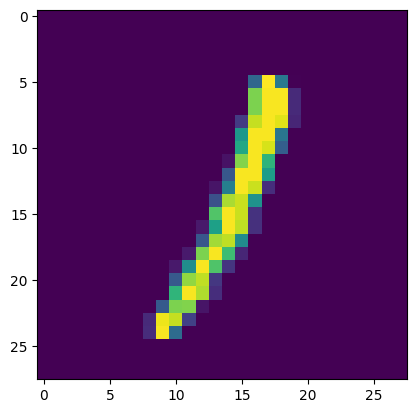

Label:  5


In [47]:
#attention: usig matplot and tensorflow in the same noetbooks may cause crashes

from matplotlib import pyplot as plt
plt.imshow(x_train[99], interpolation='nearest')
plt.show()

print("Label: ", y_train[0])

## Build a machine learning model

Build a `tf.keras.Sequential` model by stacking layers.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_10 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 10)             │         1,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 10)             │           110 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,210 (399.26 KB)

 Trainable params: 102,210 (399.26 KB)

 Non-trainable params: 0 (0.00 B)

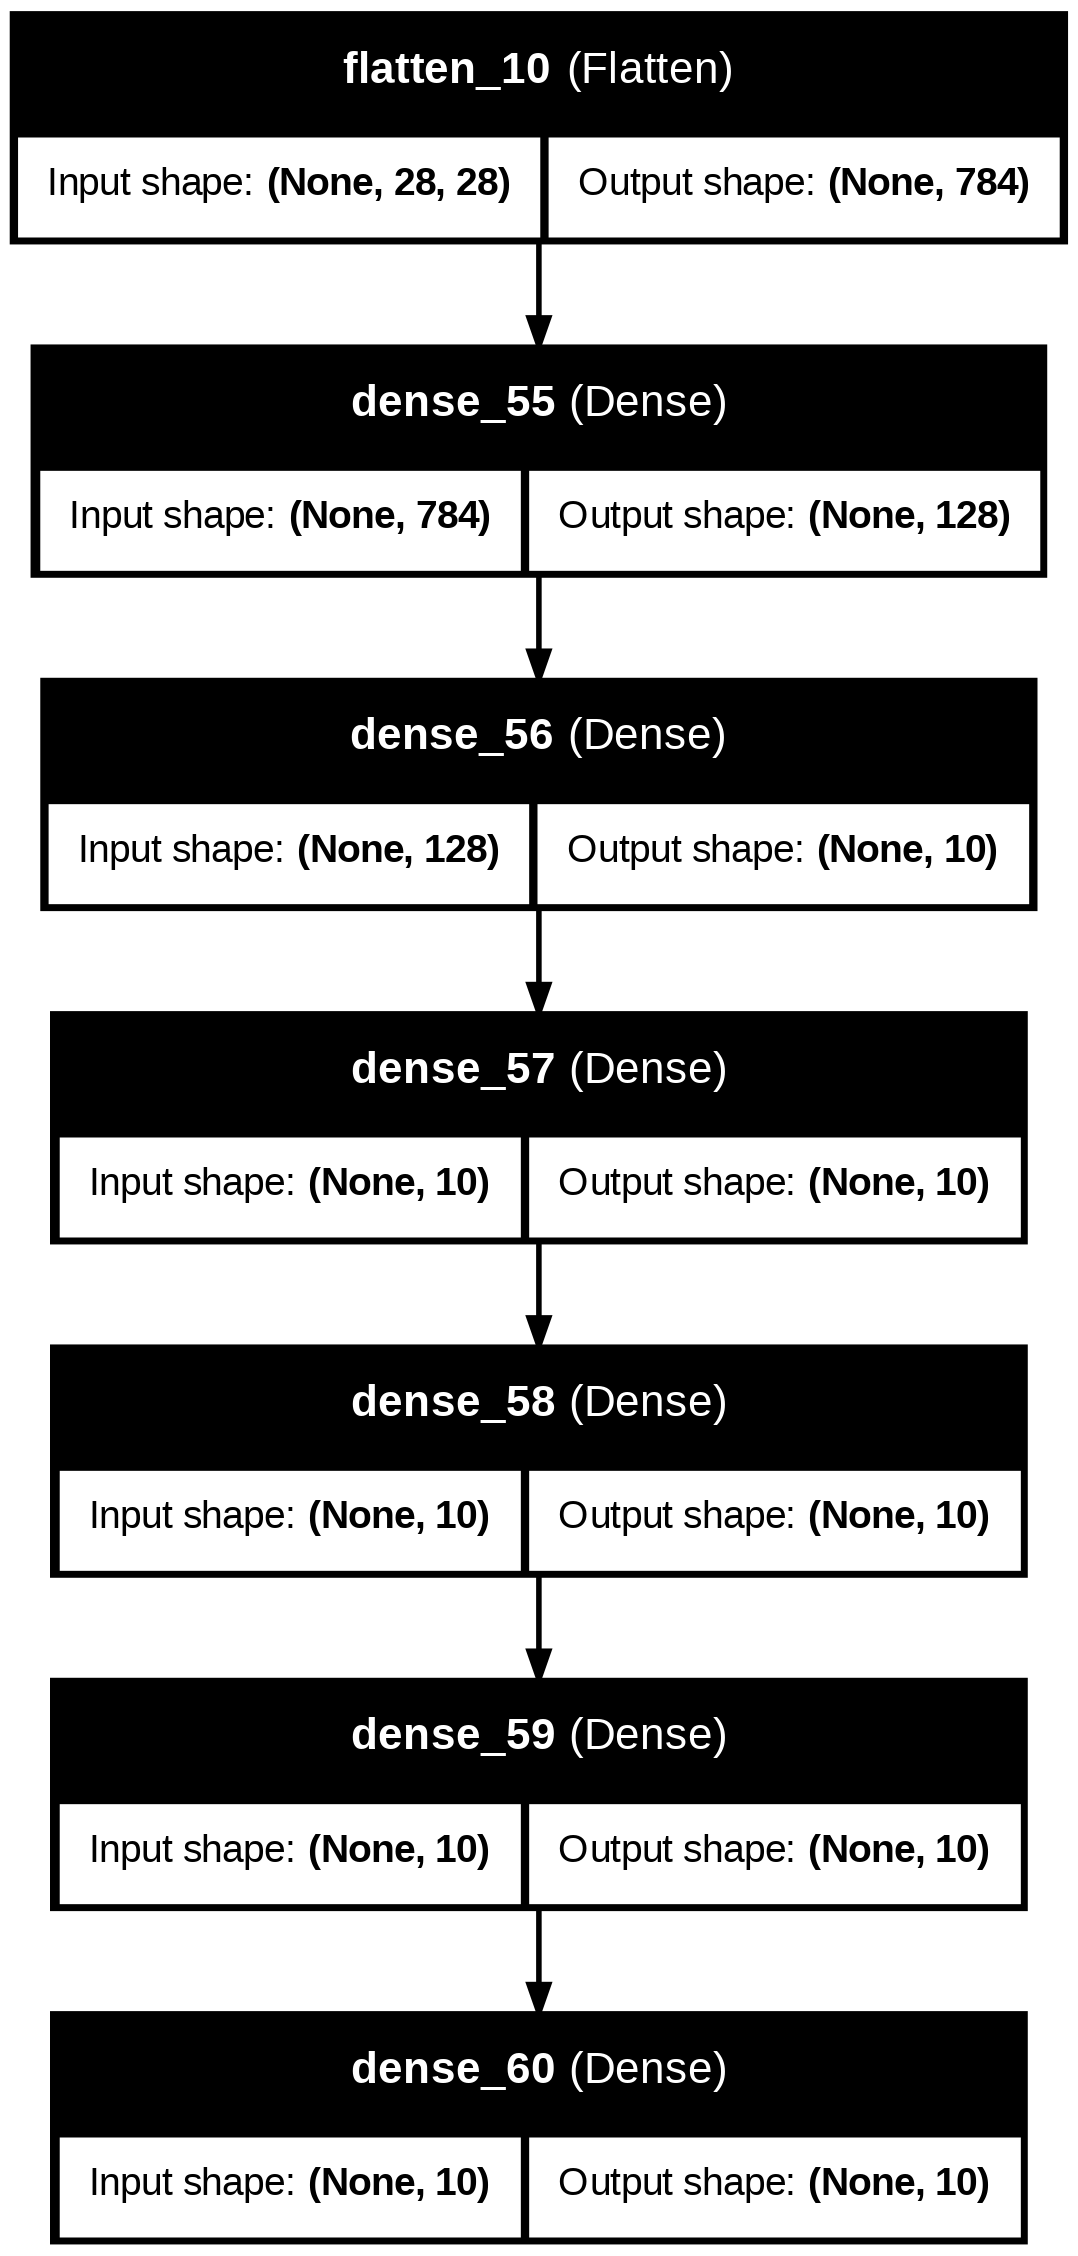

In [48]:
import os

os.makedirs("../img", exist_ok=True)

model = ks.models.Sequential([
  #Input layer created implicitly
  ks.layers.Flatten(input_shape=(28, 28)),#  reshape input (28 x 28) array to 1-D array, creating 784 nodes, one for each pixel
  ks.layers.Dense(128, activation='relu'), # Dense: all (128) nodes are connected to all preceding nodes
  ks.layers.Dense(10), # this is our output layer, with one node for each number
  ks.layers.Dense(10),
  ks.layers.Dense(10),
  ks.layers.Dense(10),
  ks.layers.Dense(10),
])

model.summary()

tf.keras.utils.plot_model(
model, to_file='../img/model_plot.png', show_shapes=True, show_layer_names=True)

For each example, the model returns a vector of [logits](https://developers.google.com/machine-learning/glossary#logits) or [log-odds](https://developers.google.com/machine-learning/glossary#log-odds) scores, one for each class.

In [49]:
predictions = model(x_train[:1]).numpy()
predictions

array([[ 0.17813806, -0.2481109 ,  0.275767  , -0.27485088, -0.00532775,
        -0.12546188,  0.11545868, -0.45340955,  0.27085736, -0.22349012]],
      dtype=float32)

The `tf.nn.softmax` function converts these logits to *probabilities* for each class:

In [50]:
tf.nn.softmax(predictions).numpy()

array([[0.12196364, 0.07963662, 0.13447145, 0.07753535, 0.10152013,
        0.0900282 , 0.11455368, 0.06485639, 0.13381286, 0.08162167]],
      dtype=float32)

Note: It is possible to bake the `tf.nn.softmax` function into the activation function for the last layer of the network. While this can make the model output more directly interpretable, this approach is discouraged as it's impossible to provide an exact and numerically stable loss calculation for all models when using a softmax output.

Define a loss function for training using `losses.SparseCategoricalCrossentropy`, which takes a vector of logits and a `True` index and returns a scalar loss for each example.

In [51]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

This loss is equal to the negative log probability of the true class: The loss is zero if the model is sure of the correct class.

This *untrained model* gives probabilities close to random (1/10 for each class), so the initial loss should be close to `-tf.math.log(1/10) ~= 2.3`.

In [52]:
loss_fn(y_train[:1], predictions).numpy()

np.float32(2.4076324)

Before you start training, configure and compile the model using Keras `Model.compile`. Set the [`optimizer`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) class to `adam`, set the `loss` to the `loss_fn` function you defined earlier, and specify a metric to be evaluated for the model by setting the `metrics` parameter to `accuracy`.

In [53]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])


## Train and evaluate your model
Now its tiem to **train** our model, meanning we use labled data to tune our model such that the predicted labels mach as closely as possible to the actual labels. We do this over many *steps* in multiple *epochs*;

* Epoch: A training epoch represents a complete use of all training data for gradients calculation and optimizations(train the model).

* Step: A training step means using one batch size of training data to train the model.

Use the `Model.fit` method to adjust your model parameters and minimize the loss (i.e. *train* the model). The training will take up to a minute and you can ovserve how the loss and accuracy on the test dataset change over time:

In [54]:
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.8236 - loss: 0.5533
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.9643 - loss: 0.1210
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9766 - loss: 0.0781
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.9816 - loss: 0.0588
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9860 - loss: 0.0436



Congartualtions! you just trained your first Neural Network model!


The `Model.evaluate` method checks the models performance, usually on a "[Validation-set](https://developers.google.com/machine-learning/glossary#validation-set)" or "[Test-set](https://developers.google.com/machine-learning/glossary#test-set)".

For this we let the model predict the label of a dataset it was not trained on and check how acurate it was.

In [33]:
model.evaluate(x_test,  y_test, verbose=2)

313/313 - 1s - 3ms/step - accuracy: 0.9748 - loss: 0.0954


[0.09543082863092422, 0.9747999906539917]

The image classifier is now trained to ~98% accuracy on this dataset. To learn more, read the [TensorFlow tutorials](https://www.tensorflow.org/tutorials/).

If you want your model to return a probability, you can wrap the trained model, and attach the softmax to it:

In [34]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

For example, lets predict the label of the first entry in the test dataset

In [35]:
import numpy as np
Prediction= probability_model(x_test[:1])
Prediction

print("True Label: {} \nPredicted Label: {} with probability: {:0.3f} %".format(np.argmax(Prediction),y_test[0] ,Prediction[0,np.argmax(Prediction)]*100))

True Label: 7 
Predicted Label: 7 with probability: 99.997 %


## Conclusion

Congratulations! You have trained a machine learning model using a prebuilt dataset using the [Keras](https://www.tensorflow.org/guide/keras/overview) API.

For more examples of using Keras, check out the [tutorials](https://www.tensorflow.org/tutorials/keras/). To learn more about building models with Keras, read the [guides](https://www.tensorflow.org/guide/keras). If you want learn more about loading and preparing data, see the tutorials on [image data loading](https://www.tensorflow.org/tutorials/load_data/images) or [CSV data loading](https://www.tensorflow.org/tutorials/load_data/csv).


*adapted from : https://www.tensorflow.org/tutorials/quickstart/beginner*